<a href="https://colab.research.google.com/github/Yagwar/Proyectos/blob/master/Resolve_Alexis_Carrillo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, pickle
import matplotlib
matplotlib.style.use("seaborn")

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = 'gdrive/My Drive/Freelancer/Resolve Studio/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Time sample para los gráficos de series de tiempo
time_sample="3600s"#'1440T'#"1800S"#"900S"#"3600s"#

# Carga y Preprocesamiento

In [4]:
conversiones=pd.read_excel(drive_path+"Conversiones.xlsx");print(conversiones.sample(5).T)
parrilla=pd.read_excel(drive_path+"Parrilla.xlsx");print(parrilla.sample(5).T)
interacciones=pd.read_excel(drive_path+"Interacciones.xlsx");print(interacciones.sample(5).T)
analitica=pd.read_excel(drive_path+"Analitica.xlsx");print(analitica.sample(5).T)
demografia=pd.read_excel(drive_path+"Demografía.xlsx");print(demografia.sample(5).T)

                                                     90  ...                        87
Campaña                                        Toma Más  ...                  La mejor
Grupo                                                 4  ...                         1
Asistente                                             5  ...                         4
Creatividad                               Te lo mereces  ...              Innigualable
Número objetivo de conversión                       207  ...                       329
Fecha                          2019-06-02T00:00:00.000Z  ...  2019-06-02T00:00:00.000Z
Medio                                                 3  ...                         3
source                                                3  ...                         3
Total de conversiones                               248  ...                       164

[9 rows x 5 columns]
                                  91  ...                        22
channel                          RCN  ..

In [0]:
conversiones.Fecha=pd.to_datetime(conversiones.Fecha).dt.tz_convert("America/Bogota")
parrilla.start_date=pd.to_datetime(parrilla.start_date).dt.tz_convert("America/Bogota")
parrilla.end_date=pd.to_datetime(parrilla.end_date).dt.tz_convert("America/Bogota")
analitica.Fecha=pd.to_datetime(analitica.Fecha).dt.tz_convert("America/Bogota")
demografia.Fecha=pd.to_datetime(demografia.Fecha).dt.tz_convert("America/Bogota")
interacciones.Fecha=pd.to_datetime(pd.DataFrame({"year":interacciones["Fecha"].dt.year,
                                                 "month":interacciones["Fecha"].dt.month,
                                                 "day":interacciones["Fecha"].dt.day,
                                                 "hour":interacciones["hour"],
                                                 "minute":interacciones["minute"]})).dt.tz_localize("UTC").dt.tz_convert("America/Bogota")

In [0]:
interacciones=interacciones.iloc[:,:4]

In [0]:
analitica.Medio=pd.Categorical(analitica.Medio)
analitica.Fuente=pd.Categorical(analitica.Fuente) 
demografia.browser=pd.Categorical(demografia.browser)
demografia.Ciudad=pd.Categorical(demografia.Ciudad)
demografia["Sistema Operativo"]=pd.Categorical(demografia["Sistema Operativo"])
demografia.ID=demografia.ID.apply(str)
parrilla.channel=pd.Categorical(parrilla.channel)
parrilla.Formato=pd.Categorical(parrilla.Formato)
parrilla.medium=pd.Categorical(parrilla.medium)
interacciones.ID=interacciones.ID.apply(str)
conversiones.Campaña=pd.Categorical(conversiones.Campaña)
conversiones.Grupo=pd.Categorical(conversiones.Grupo)
conversiones.Asistente=pd.Categorical(conversiones.Asistente)
conversiones.Medio=pd.Categorical(conversiones.Medio)
conversiones.source=pd.Categorical(conversiones.source)
conversiones.Creatividad=pd.Categorical(conversiones.Creatividad)

In [0]:
# analitica.dtypes
# demografia.dtypes
# parrilla.dtypes
# interacciones.dtypes
# conversiones.dtypes

In [0]:
analitica.set_index('Fecha', inplace=True)
demografia.set_index('Fecha', inplace=True)
parrilla.set_index('start_date', inplace=True)
interacciones.set_index('Fecha', inplace=True)
conversiones.set_index('Fecha', inplace=True)

# Exploración de datos

In [0]:
# conversiones.sample(20)
# interacciones.sample(20)
# parrilla.sample(20)
# analitica.sample(20)
# demografia.sample(20)

## Analítica

In [11]:
[print(analitica[column].value_counts()) for column in analitica.columns if not(analitica[column].dtype=="int64")]#

Pepsi             27
Cocacola          26
Aceite de coco    18
Andina            16
Poker             13
Name: Marca, dtype: int64
Lo que te hace falta    37
La mejor                35
Toma más                28
Name: Campaña, dtype: int64
Televisión    42
Radio         32
Internet      26
Name: Medio, dtype: int64
RCN         34
Semana      24
Uno         23
Facebook    19
Name: Fuente, dtype: int64


[None, None, None, None]

### Univariado 
Todas respecto a conversiones

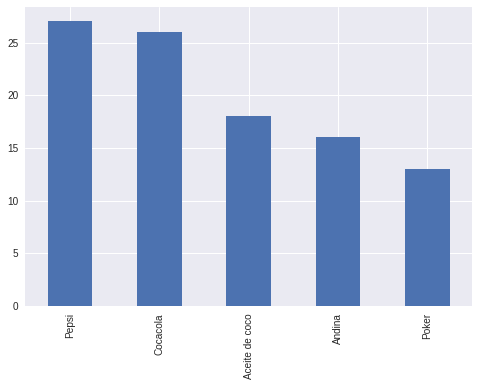

In [12]:
analitica.Marca.value_counts().plot(kind="bar")

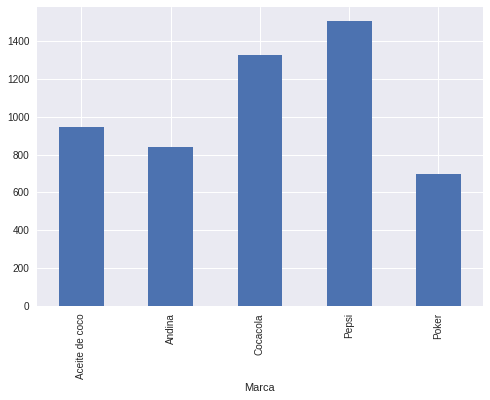

In [13]:
analitica.groupby('Marca')['conversion'].sum().plot(kind="bar")

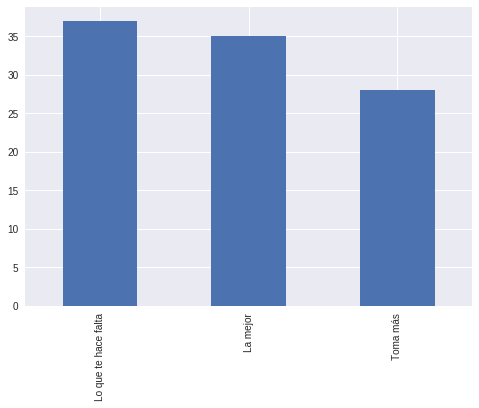

In [14]:
analitica.Campaña.value_counts().plot(kind="bar")

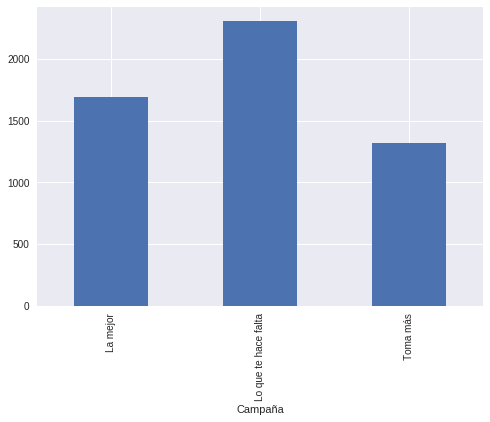

In [15]:
analitica.groupby('Campaña')['conversion'].sum().plot(kind="bar")

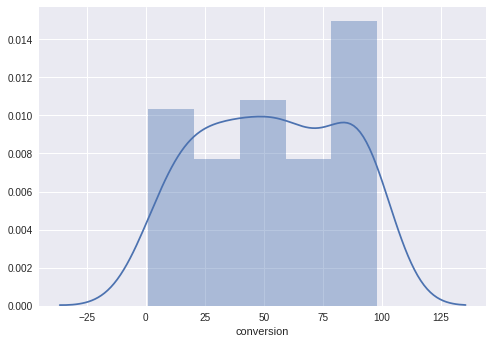

In [16]:
sns.distplot(analitica.conversion)

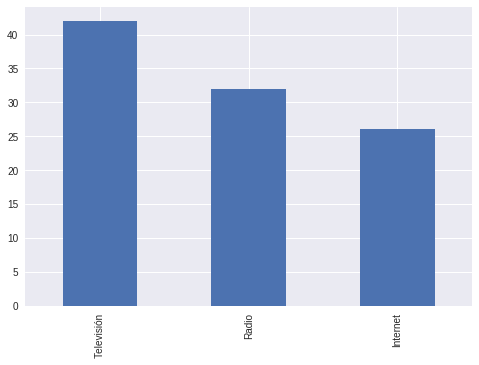

In [17]:
analitica.Medio.value_counts().plot(kind="bar")

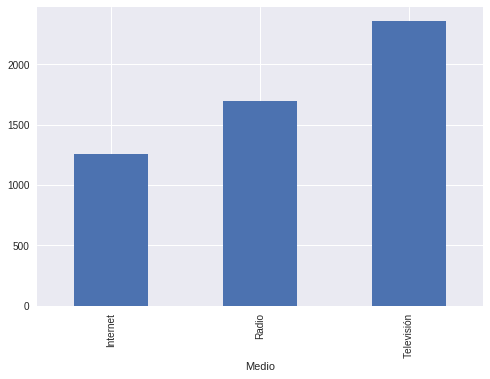

In [18]:
analitica.groupby('Medio')['conversion'].sum().plot(kind="bar")

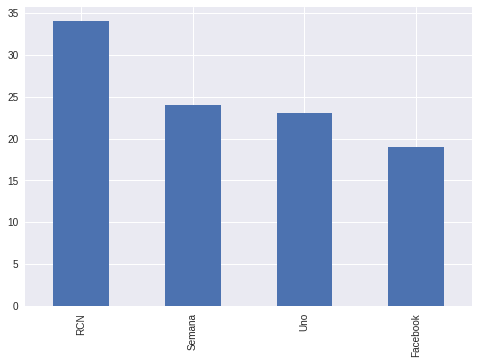

In [19]:
analitica.Fuente.value_counts().plot(kind="bar")

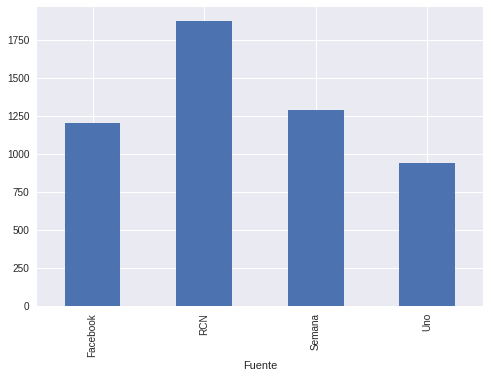

In [20]:
analitica.groupby('Fuente')['conversion'].sum().plot(kind="bar")

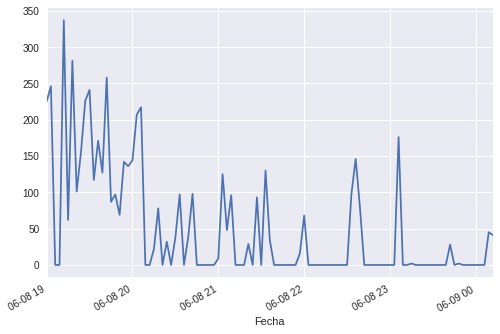

In [21]:
analitica.conversion.resample("180s").sum().plot()#kind="bar")

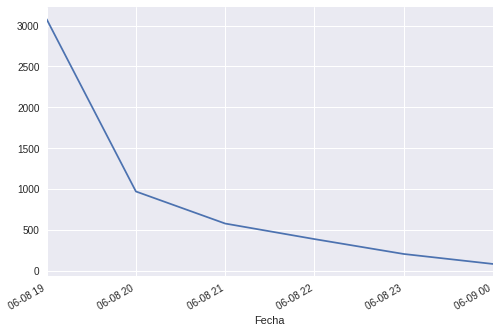

In [22]:
analitica.conversion.resample("3600s").sum().plot()#kind="bar")

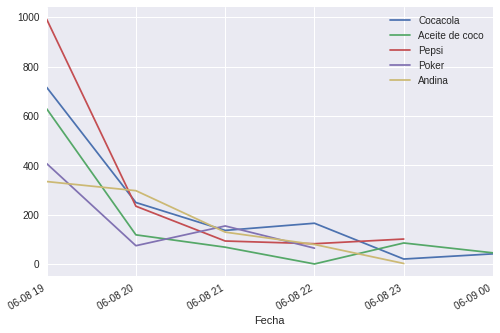

In [23]:
pd.DataFrame({sponsor:analitica.loc[analitica.Marca==sponsor,"conversion"].resample(time_sample).sum() for sponsor in list(set(analitica.Marca))}).plot()#kind="bar")

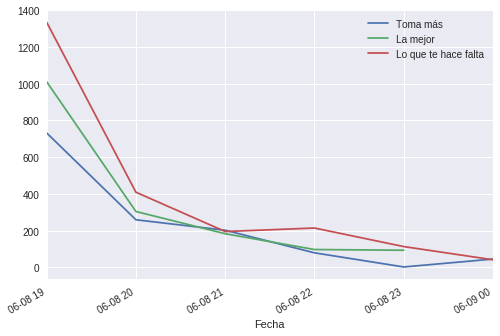

In [24]:
pd.DataFrame({sponsor:analitica.loc[analitica.Campaña==sponsor,"conversion"].resample(time_sample).sum() for sponsor in list(set(analitica.Campaña))}).plot()#kind="bar")

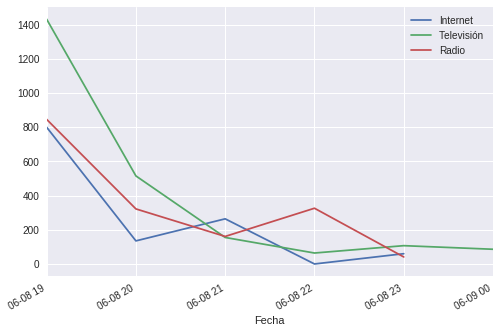

In [25]:
pd.DataFrame({sponsor:analitica.loc[analitica.Medio==sponsor,"conversion"].resample(time_sample).sum() for sponsor in list(set(analitica.Medio))}).plot()

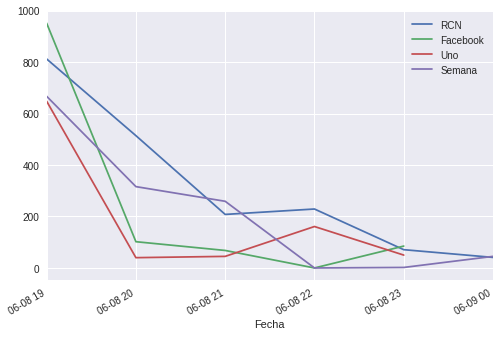

In [26]:
pd.DataFrame({sponsor:analitica.loc[analitica.Fuente==sponsor,"conversion"].resample(time_sample).sum() for sponsor in list(set(analitica.Fuente))}).plot()

### Prueba estadística

In [27]:
model_analitica = ols('conversion ~ C(Marca)+C(Campaña)+C(Medio)+C(Fuente)', analitica).fit()

print(f"Overall model F({model_analitica.df_model: .0f},{model_analitica.df_resid: .0f}) = {model_analitica.fvalue: .3f}, p = {model_analitica.f_pvalue: .4f}")

Overall model F( 11, 88) =  1.117, p =  0.3582


In [28]:
model_analitica.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.117
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.358
Time:                        05:44:02   Log-Likelihood:                -473.57
No. Observations:                 100   AIC:                             971.1
Df Residuals:                      88   BIC:                             1002.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             56.3026     11.778      4.780      0.000      32.897      79.708
C(Marca)[T.Andina]                     2.0953     10.548      0.199      0.843     -18.867      23.058
C(Marca)[T.Cocacola]                  -2.5838      9.369     -0.276      0.783     -21.202      16.035
C(Marca)[T.Pepsi]                      2.1149      9.183      0.230      0.818     -16.134      20.363
C(Marca)[T.Poker]                      0.6766     10.818      0.063      0.950     -20.821      22.174
C(Campaña)[T.Lo que te hace falta]    11.5444      7.254      1.591      0.115      -2.871      25.960
C(Campaña)[T.Toma más]                -3.3144      8.162     -0.406      0.686     -19.535      12.906
C(Medio)[T.Radio]                      1.0633      8.153      0.130      0.897     -15.140      17.267
C(Medio)[T.Televisión]                 4.4397      7.620      0.583      0.562     -10.703      19.583
C(Fuente)[T.RCN]                      -7.0139      8.744     -0.802      0.425     -24.391      10.363
C(Fuente)[T.Semana]                   -7.4920      9.574     -0.783      0.436     -26.519      11.535
C(Fuente)[T.Uno]                     -21.0894      9.391     -2.246      0.027     -39.752      -2.427
==============================================================================
Omnibus:                        7.036   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                2.984
Skew:                           0.051   Prob(JB):                        0.225
Kurtosis:                       2.160   Cond. No.                         8.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
res_analitica = sm.stats.anova_lm(model_analitica, typ= 2)
res_analitica

,sum_sq,df,F,PR(>F)
C(Marca),347.150330,4.0,0.100475,0.982023
C(Campaña),3611.253361,2.0,2.090401,0.129735
C(Medio),348.091765,2.0,0.201495,0.817883
C(Fuente),4875.219806,3.0,1.881371,0.138562
Residual,76011.816704,88.0,NaN,NaN


###  Conclusiones Base de datos Analítica
- Los datos varían a lo largo de las horas:
  - Probablemente haya diferencias por *prime time* vs otras franjas. 
  - Las conversiones tienden a concentrarse entre las 7:00 y 8:10 de la noche.
  - Es mejor abordarlo desde el enfoque de series temporales.
  
- Es poco viable un modelo de regresión (lineal o no lineal) para predecir las conversiones:
  - Las variables predictoras son categóricas y la variable criterio es continua. Volver todas las predictoras variables dummy no aporta suficiente información a los algoritmos por la maldición de la dimensionalidad.
  - La pruena estadística ANOVA de N vías señaló que las diferencias entre los grupos de las variables predictoras no son lo suficientemente grandes como para identificar una variable que tenga un comportamiento diferencial frente a las conversiones.
  - No hay suficientes datos como para entrenar un algoritmo de manera robusta.

## Demografía

In [0]:
demografia.columns=['browser', 'Ciudad', 'device', 'ID', 'Sistema_Operativo', 'Sesión ', 'Duración', 'Tiempo_en_página']

In [31]:
demografia.sample(15)

,browser,Ciudad,device,ID,Sistema_Operativo,Sesión,Duración,Tiempo_en_página
Fecha,,,,,,,,
2019-05-31 20:51:00-05:00,Chrome,Guaspí,mobile,1714,Android,10,55,24
2019-05-31 23:24:00-05:00,Chrome,Guaspí,mobile,1888,Android,10,26,59
2019-05-31 19:57:00-05:00,Safari,Bogotá,mobile,1224,iOS,4,50,49
2019-05-31 20:16:00-05:00,Chrome,Bogotá,mobile,1126,Android,2,48,17
2019-06-01 00:31:00-05:00,Chrome,Caracas,mobile,1042,Android,3,32,38
2019-05-31 19:21:00-05:00,Chrome,Bogotá,mobile,1354,Android,10,56,30
2019-05-31 21:23:00-05:00,Chrome,Caracas,mobile,1156,Android,4,17,48
2019-05-31 19:04:00-05:00,Chrome,Caracas,mobile,1400,Android,5,21,22
2019-05-31 21:17:00-05:00,Chrome,Cereté,mobile,1489,Android,6,29,60


In [32]:
demografia.dtypes

browser              category
Ciudad               category
device                 object
ID                     object
Sistema_Operativo    category
Sesión                  int64
Duración                int64
Tiempo_en_página        int64
dtype: object

In [33]:
[print(demografia[column].value_counts()) for column in demografia.columns if not(demografia[column].dtype=="int64")]#

Chrome    94
Safari     6
Name: browser, dtype: int64
Guaspí     22
Cereté     20
Tunja      15
Dallas     15
Caracas    14
Bogotá     14
Name: Ciudad, dtype: int64
mobile     82
desktop    18
Name: device, dtype: int64
1224    2
1968    1
1606    1
1797    1
1105    1
1709    1
1489    1
1756    1
1179    1
1482    1
1414    1
1701    1
1431    1
1900    1
1309    1
1876    1
1197    1
1449    1
1135    1
1337    1
1984    1
1462    1
1400    1
1088    1
1420    1
1779    1
1265    1
1208    1
1585    1
1164    1
       ..
1554    1
1133    1
1303    1
1972    1
1469    1
1354    1
1624    1
1787    1
1553    1
1378    1
1835    1
1136    1
1893    1
1754    1
1677    1
1848    1
1384    1
1321    1
1745    1
1143    1
1276    1
1098    1
1965    1
1153    1
1947    1
1156    1
1042    1
1812    1
1447    1
1282    1
Name: ID, Length: 99, dtype: int64
Android    72
Windows    17
iOS        10
Linux       1
Name: Sistema_Operativo, dtype: int64


[None, None, None, None, None]

### Univariado

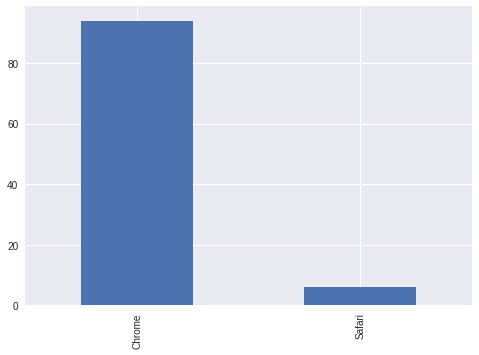

In [34]:
demografia.browser.value_counts().plot(kind="bar")

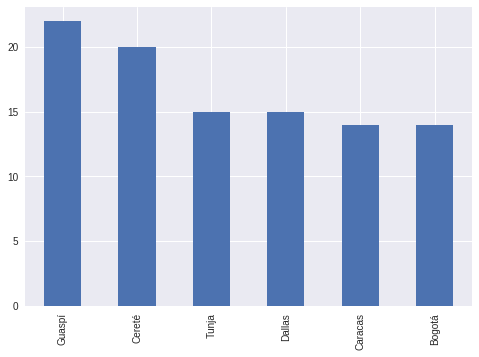

In [35]:
demografia.Ciudad.value_counts().plot(kind="bar")

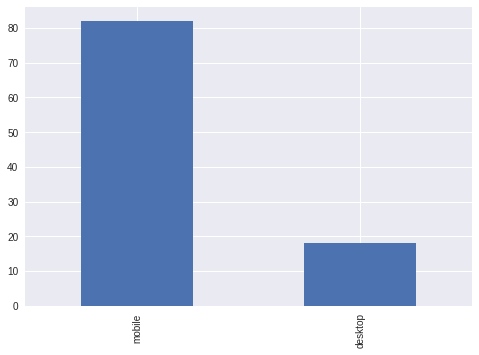

In [36]:
demografia.device.value_counts().plot(kind="bar")

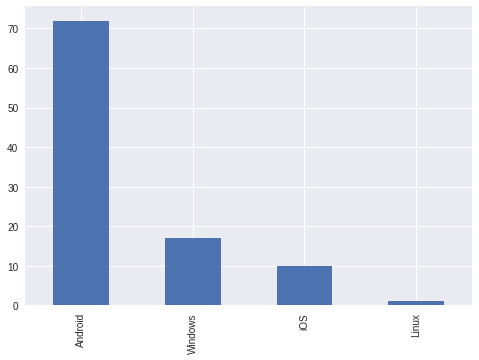

In [37]:
demografia.Sistema_Operativo.value_counts().plot(kind="bar")

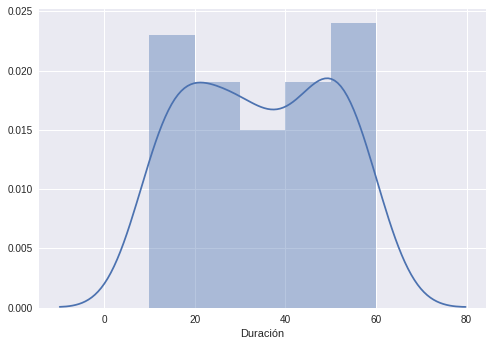

In [38]:
sns.distplot(demografia.Duración)

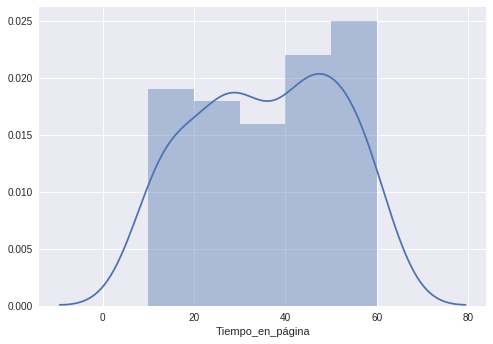

In [39]:
sns.distplot(demografia.Tiempo_en_página)

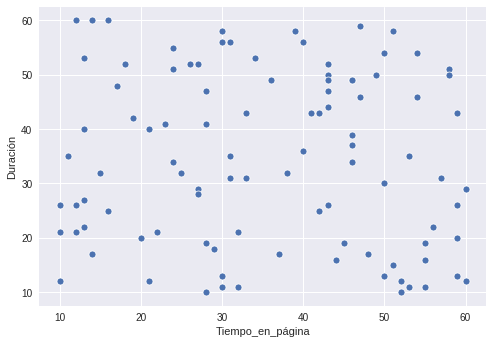

In [40]:
sns.scatterplot(x="Tiempo_en_página", y="Duración", data=demografia)

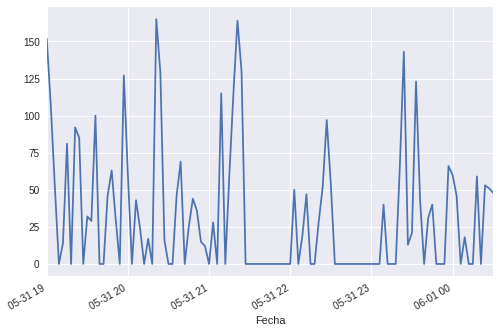

In [41]:
demografia["Tiempo_en_página"].resample("180s").sum().plot()#kind="bar")

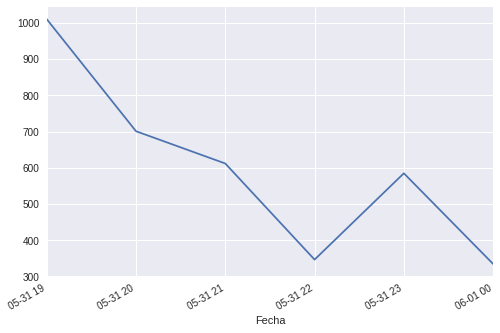

In [42]:
demografia["Tiempo_en_página"].resample("3600s").sum().plot()#kind="bar")

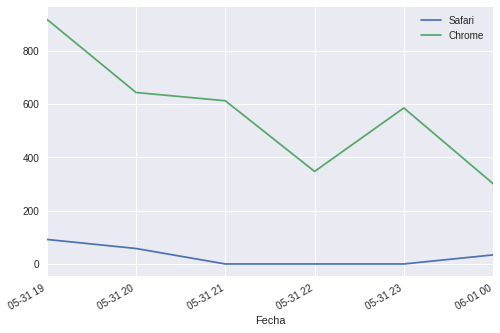

In [43]:
pd.DataFrame({tag_val:demografia.loc[demografia.browser==tag_val,"Tiempo_en_página"].resample(time_sample).sum() for tag_val in list(set(demografia.browser))}).plot()#kind="bar")

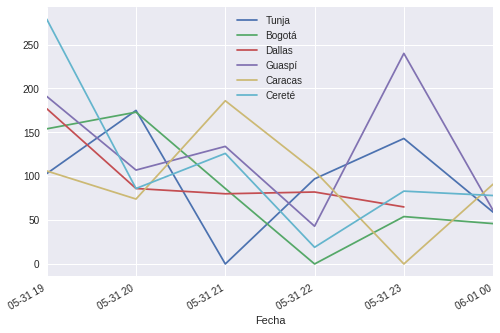

In [44]:
pd.DataFrame({tag_val:demografia.loc[demografia.Ciudad==tag_val,"Tiempo_en_página"].resample(time_sample).sum() for tag_val in list(set(demografia.Ciudad))}).plot()#kind="bar")

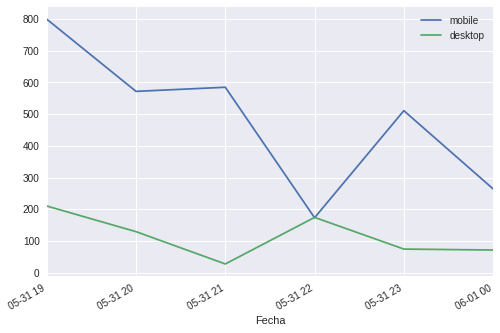

In [45]:
pd.DataFrame({tag_val:demografia.loc[demografia.device==tag_val,"Tiempo_en_página"].resample(time_sample).sum() for tag_val in list(set(demografia.device))}).plot()#kind="bar")

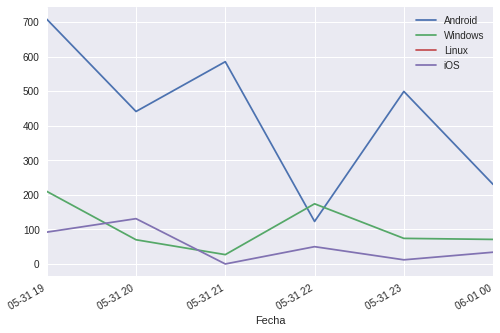

In [46]:
pd.DataFrame({tag_val:demografia.loc[demografia.Sistema_Operativo==tag_val,"Tiempo_en_página"].resample(time_sample).sum() for tag_val in list(set(demografia.Sistema_Operativo))}).plot()#kind="bar")

### Prueba estadística

In [47]:
model_demografia = ols('Tiempo_en_página ~ C(browser)+C(Ciudad)+C(device)+C(Sistema_Operativo)', demografia).fit()

print(f"Overall model F({model_demografia.df_model: .0f},{model_demografia.df_resid: .0f}) = {model_demografia.fvalue: .3f}, p = {model_demografia.f_pvalue: .4f}")

Overall model F( 9, 90) =  0.621, p =  0.7764


In [48]:
model_demografia.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Tiempo_en_página   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.6208
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.776
Time:                        05:44:07   Log-Likelihood:                -411.59
No. Observations:                 100   AIC:                             843.2
Df Residuals:                      90   BIC:                             869.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          32.5438      4.569      7.122      0.000      23.466      41.622
C(browser)[T.Safari]               -2.4759     10.416     -0.238      0.813     -23.169      18.217
C(Ciudad)[T.Caracas]                4.6360      6.130      0.756      0.451      -7.542      16.814
C(Ciudad)[T.Cereté]                -1.7505      5.615     -0.312      0.756     -12.906       9.405
C(Ciudad)[T.Dallas]                -2.7104      5.968     -0.454      0.651     -14.566       9.145
C(Ciudad)[T.Guaspí]                 0.4444      5.519      0.081      0.936     -10.521      11.410
C(Ciudad)[T.Tunja]                  3.6466      6.007      0.607      0.545      -8.287      15.580
C(device)[T.mobile]                 3.0219      4.676      0.646      0.520      -6.268      12.312
C(Sistema_Operativo)[T.Linux]      26.4562     11.964      2.211      0.030       2.687      50.225
C(Sistema_Operativo)[T.Windows]     3.0658      5.401      0.568      0.572      -7.664      13.795
C(Sistema_Operativo)[T.iOS]        -2.9614      8.324     -0.356      0.723     -19.499      13.576
==============================================================================
Omnibus:                       20.024   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.965
Skew:                          -0.067   Prob(JB):                       0.0836
Kurtosis:                       1.917   Cond. No.                     1.09e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.6e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [49]:
res_demografia = sm.stats.anova_lm(model_demografia, typ= 2)
res_demografia

,sum_sq,df,F,PR(>F)
C(browser),13.816263,1.0,0.056504,0.812650
C(Ciudad),635.275416,5.0,0.519611,0.760822
C(device),102.110334,1.0,0.417595,0.519784
C(Sistema_Operativo),5635.538422,3.0,7.682458,0.000126
Residual,22006.778506,90.0,NaN,NaN


###  Conclusiones Base de datos Demografía
- Los datos varían a lo largo de las horas (Al igual que Analíticos)
  
- Es poco viable un modelo de regresión (lineal o no lineal) para predecir el tiempo que pasa una persona interactuando en la página:
  - Las variables predictoras son categóricas y la variable criterio es continua. Volver todas las predictoras variables dummy no aporta suficiente información a los algoritmos por la maldición de la dimensionalidad.
  - La prueba estadística ANOVA de N vías señaló que las diferencias entre los grupos de las variables predictoras no son lo suficientemente grandes como para identificar una variable que tenga un comportamiento diferencial frente a las conversiones.
  - No hay suficientes datos como para entrenar un algoritmo de manera robusta.

## Parrilla

In [50]:
parrilla.sample(15)

,channel,end_date,Formato,inversion,medium,rating,reference
start_date,,,,,,,
2019-06-04 03:43:02-05:00,Caracol,2019-06-04 03:43:22-05:00,Corto,894540,Radio,10,Disfrutala
2019-06-04 06:12:54-05:00,RCN,2019-06-04 06:13:14-05:00,Largo,32300,Televisión,5,Tomala
2019-06-05 05:44:35-05:00,Caracol,2019-06-05 05:44:55-05:00,Largo,710500,Internet,4,Disfrutala
2019-06-05 10:37:12-05:00,RCN,2019-06-05 10:37:32-05:00,Largo,64600,Radio,5,Disfrutala
2019-06-03 06:21:58-05:00,RCN,2019-06-03 06:22:18-05:00,Corto,32300,Televisión,4,Tomala
2019-06-04 15:23:23-05:00,RCN,2019-06-04 15:23:43-05:00,Corto,107666,Internet,8,Tomala
2019-06-04 08:32:27-05:00,Caracol,2019-06-04 08:32:47-05:00,Corto,572758,Radio,2,Disfrutala
2019-06-05 03:07:38-05:00,Caracol,2019-06-05 03:07:58-05:00,Largo,872333,Radio,4,Disfrutala
2019-06-07 04:38:33-05:00,RCN,2019-06-07 04:38:53-05:00,Corto,32300,Internet,9,Tomala


In [51]:
[print(parrilla[column].value_counts()) for column in parrilla.columns if parrilla[column].dtype=="O"]#not(parrilla[column].dtype=="int64")]

Disfrutala    51
Tomala        49
Name: reference, dtype: int64


[None]

### Univariado

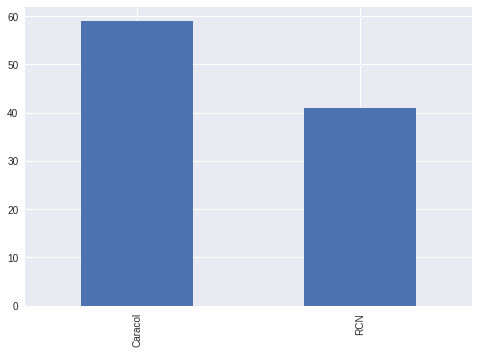

In [52]:
parrilla.channel.value_counts().plot(kind="bar")

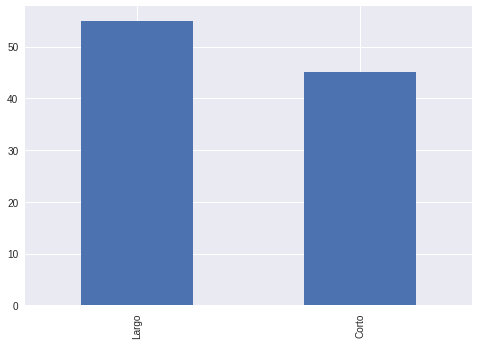

In [53]:
parrilla.Formato.value_counts().plot(kind="bar")

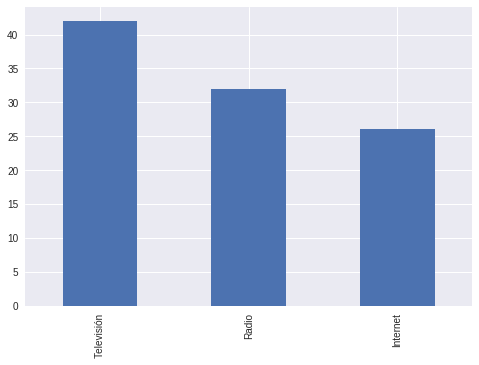

In [54]:
parrilla.medium.value_counts().plot(kind="bar")

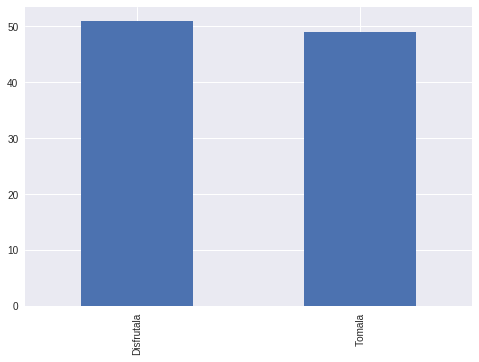

In [55]:
parrilla.reference.value_counts().plot(kind="bar") 

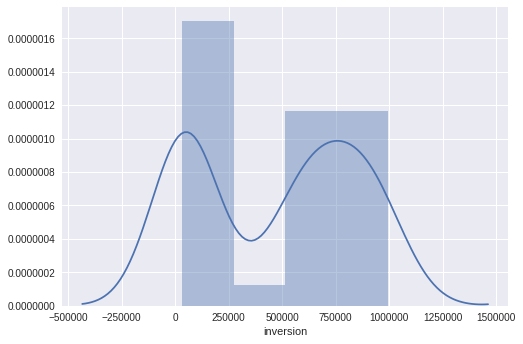

In [56]:
sns.distplot(parrilla.inversion)

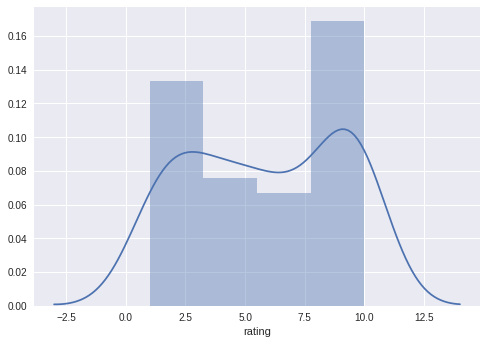

In [57]:
sns.distplot(parrilla.rating)

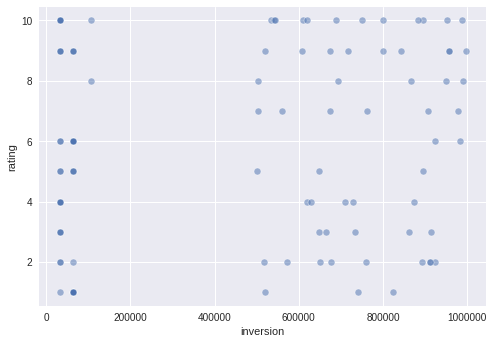

In [58]:
sns.scatterplot(x="inversion", y="rating", data=parrilla, alpha=0.5)

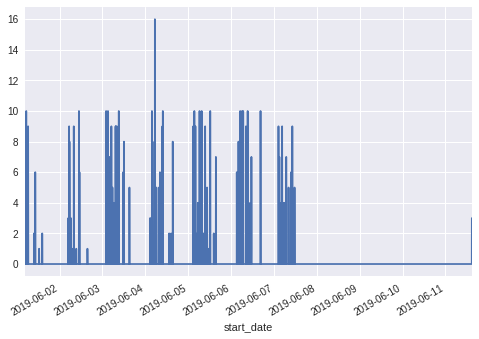

In [59]:
parrilla["rating"].resample("180s").sum().plot()#kind="bar")

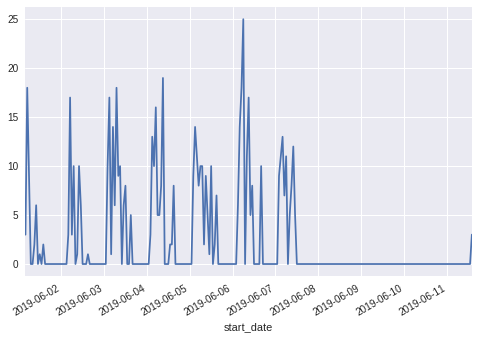

In [60]:
parrilla["rating"].resample(time_sample).sum().plot()#kind="bar")

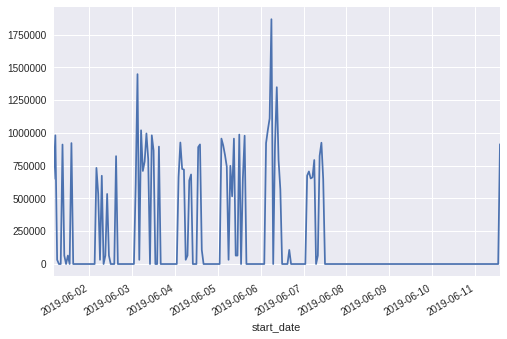

In [61]:
parrilla["inversion"].resample(time_sample).sum().plot()#kind="bar")

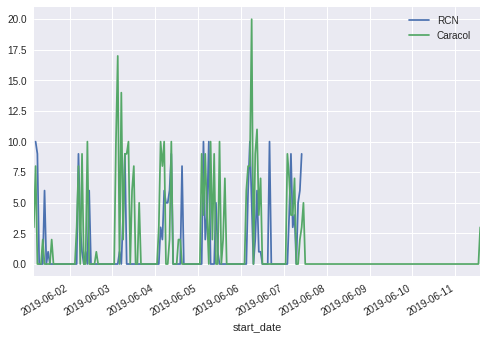

In [62]:
pd.DataFrame({tag_val:parrilla.loc[parrilla.channel==tag_val,"rating"].resample(time_sample).sum() for tag_val in list(set(parrilla.channel))}).plot()#kind="bar")

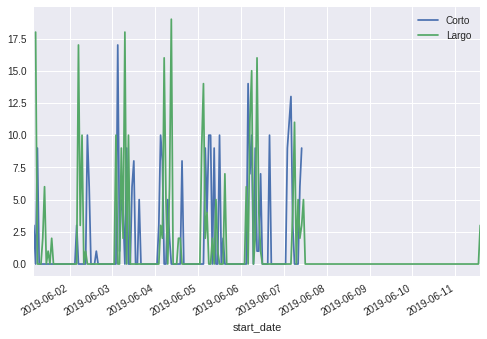

In [63]:
pd.DataFrame({tag_val:parrilla.loc[parrilla.Formato==tag_val,"rating"].resample(time_sample).sum() for tag_val in list(set(parrilla.Formato))}).plot()#kind="bar")

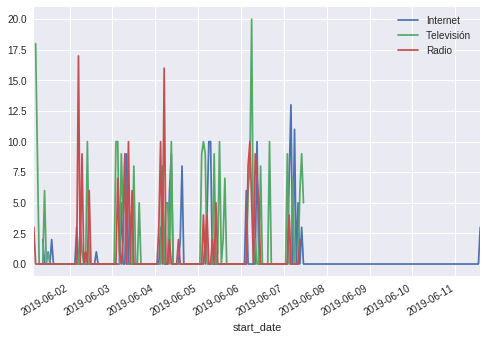

In [64]:
pd.DataFrame({tag_val:parrilla.loc[parrilla.medium==tag_val,"rating"].resample(time_sample).sum() for tag_val in list(set(parrilla.medium))}).plot()#kind="bar")

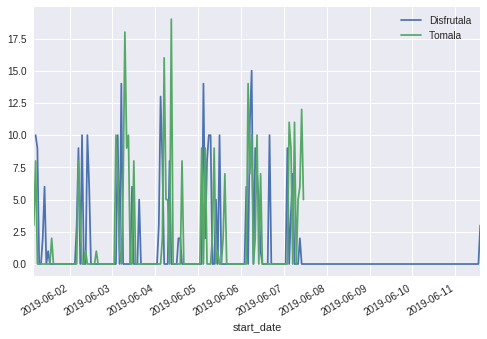

In [65]:
pd.DataFrame({tag_val:parrilla.loc[parrilla.reference==tag_val,"rating"].resample(time_sample).sum() for tag_val in list(set(parrilla.reference))}).plot()#kind="bar")

### Prueba estadística

In [66]:
model_parrilla = ols('rating ~ C(channel)+C(Formato)+C(medium)+C(reference)', parrilla).fit()

print(f"Overall model F({model_parrilla.df_model: .0f},{model_parrilla.df_resid: .0f}) = {model_parrilla.fvalue: .3f}, p = {model_parrilla.f_pvalue: .4f}")

Overall model F( 5, 94) =  1.785, p =  0.1235


In [67]:
model_parrilla.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.785
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.123
Time:                        05:44:11   Log-Likelihood:                -252.09
No. Observations:                 100   AIC:                             516.2
Df Residuals:                      94   BIC:                             531.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   5.8723      0.811      7.239      0.000       4.262       7.483
C(channel)[T.RCN]          -0.8705      0.635     -1.371      0.174      -2.132       0.391
C(Formato)[T.Largo]        -0.7998      0.630     -1.269      0.208      -2.051       0.452
C(medium)[T.Radio]          0.0618      0.823      0.075      0.940      -1.572       1.695
C(medium)[T.Televisión]     1.3166      0.780      1.689      0.095      -0.231       2.864
C(reference)[T.Tomala]      0.3710      0.626      0.593      0.555      -0.871       1.613
==============================================================================
Omnibus:                       28.862   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.692
Skew:                          -0.035   Prob(JB):                       0.0581
Kurtosis:                       1.833   Cond. No.                         5.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
res_parrilla = sm.stats.anova_lm(model_parrilla, typ= 2)
res_parrilla

,sum_sq,df,F,PR(>F)
C(channel),18.105912,1.0,1.878337,0.173787
C(Formato),15.520748,1.0,1.610148,0.207604
C(medium),39.381173,2.0,2.042734,0.135391
C(reference),3.388741,1.0,0.351554,0.554659
Residual,906.096948,94.0,NaN,NaN


## Interacciones

In [0]:
interacciones.columns=['Promedio_de_duración', 'Tiempo_en_página', 'ID']

In [70]:
interacciones.sample(15)

,Promedio_de_duración,Tiempo_en_página,ID
Fecha,,,
2019-06-05 00:28:00-05:00,33,59,1032
2019-06-04 19:03:00-05:00,10,57,1645
2019-06-04 19:01:00-05:00,14,58,1977
2019-06-04 19:07:00-05:00,47,57,1605
2019-06-05 01:26:00-05:00,12,39,1832
2019-06-05 00:55:00-05:00,50,48,1010
2019-06-05 00:40:00-05:00,41,60,1072
2019-06-05 00:10:00-05:00,23,40,1917
2019-06-05 01:02:00-05:00,35,44,1908


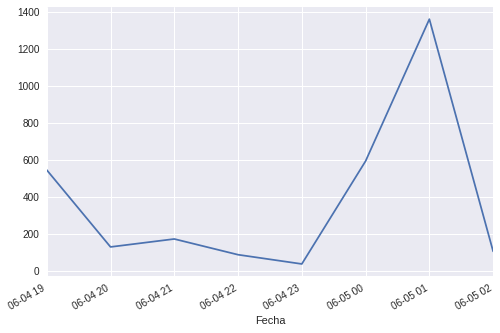

In [71]:
interacciones["Promedio_de_duración"].resample(time_sample).sum().plot()#kind="bar")

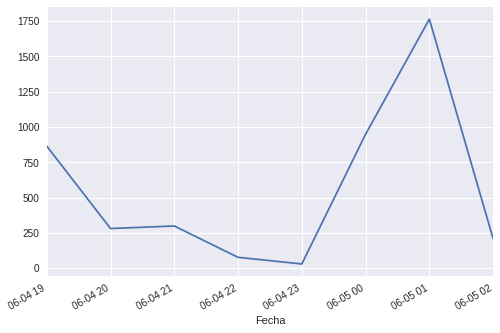

In [72]:
interacciones["Tiempo_en_página"].resample(time_sample).sum().plot()#kind="bar")

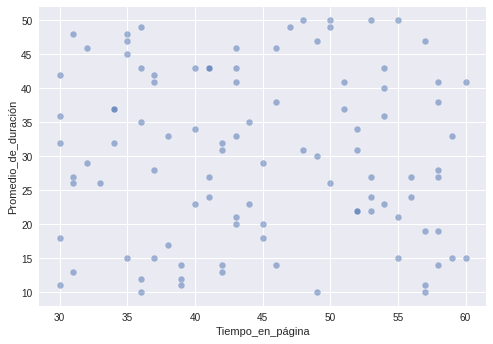

In [73]:
sns.scatterplot(x="Tiempo_en_página", y="Promedio_de_duración", data=interacciones, alpha=0.5)

##Conversiones

In [0]:
conversiones.columns=['Campaña', 'Grupo', 'Asistente', 'Creatividad','Número_objetivo_de_conversión', 'Medio', 'source','Total_de_conversiones']

In [75]:
conversiones.sample(15)

,Campaña,Grupo,Asistente,Creatividad,Número_objetivo_de_conversión,Medio,source,Total_de_conversiones
Fecha,,,,,,,,
2019-05-31 19:00:00-05:00,Toma Más,1,4,Azucaradas,118,2,2,281
2019-05-31 19:00:00-05:00,La mejor,1,3,Azucaradas,325,3,1,225
2019-05-31 19:00:00-05:00,La mejor,1,5,Azucaradas,489,3,3,286
2019-05-31 19:00:00-05:00,La mejor,4,1,Azucaradas,303,3,3,168
2019-05-31 19:00:00-05:00,Toma Más,3,1,Azucaradas,230,2,1,280
2019-05-31 19:00:00-05:00,Toma Más,5,1,Innigualable,416,3,3,219
2019-05-31 19:00:00-05:00,Lo que te hace falta,1,2,Te lo mereces,364,3,1,300
2019-05-31 19:00:00-05:00,Lo que te hace falta,2,5,Te lo mereces,493,2,4,261
2019-06-01 19:00:00-05:00,La mejor,4,5,Innigualable,238,1,5,270


In [76]:
[print(conversiones[column].value_counts()) for column in conversiones.columns if not(conversiones[column].dtype=="int64")]#if conversiones[column].dtype=="O"

Toma Más                45
Lo que te hace falta    28
La mejor                27
Name: Campaña, dtype: int64
4    33
1    26
5    14
2    14
3    13
Name: Grupo, dtype: int64
4    22
2    22
5    21
1    18
3    17
Name: Asistente, dtype: int64
Innigualable     35
Te lo mereces    34
Azucaradas       31
Name: Creatividad, dtype: int64
2    36
3    35
1    29
Name: Medio, dtype: int64
3    23
2    23
4    19
1    18
5    17
Name: source, dtype: int64


[None, None, None, None, None, None]

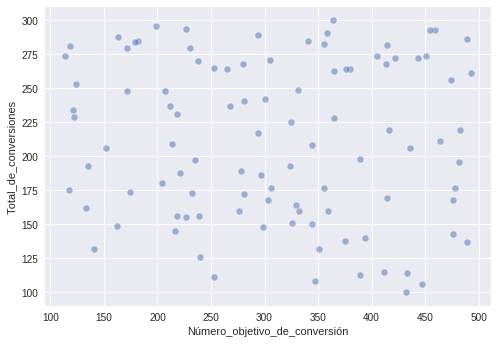

In [77]:
sns.scatterplot(x="Número_objetivo_de_conversión", y="Total_de_conversiones", data=conversiones, alpha=0.5)

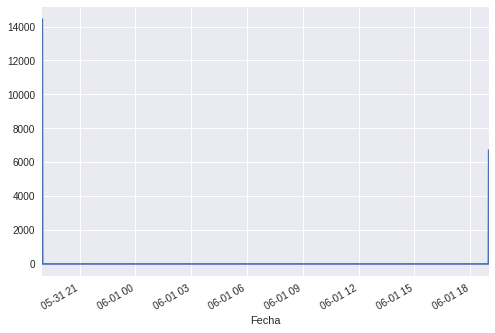

In [78]:
conversiones["Total_de_conversiones"].resample("60s").sum().plot()#kind="bar")

In [79]:
conversiones.index.value_counts()

2019-05-31 19:00:00-05:00    67
2019-06-01 19:00:00-05:00    33
Name: Fecha, dtype: int64

### Prueba estadística

In [80]:
model_conversiones = ols('Total_de_conversiones ~ C(Campaña)+C(Grupo)+C(Asistente)+C(Creatividad)+C(Medio)+C(source)', conversiones).fit()

print(f"Overall model F({model_conversiones.df_model: .0f},{model_conversiones.df_resid: .0f}) = {model_conversiones.fvalue: .3f}, p = {model_conversiones.f_pvalue: .4f}")

Overall model F( 18, 81) =  1.058, p =  0.4085


In [81]:
model_conversiones.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Total_de_conversiones   R-squared:                       0.190
Model:                               OLS   Adj. R-squared:                  0.010
Method:                    Least Squares   F-statistic:                     1.058
Date:                   Mon, 05 Aug 2019   Prob (F-statistic):              0.408
Time:                           05:44:13   Log-Likelihood:                -537.16
No. Observations:                    100   AIC:                             1112.
Df Residuals:                         81   BIC:                             1162.
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                            222.7501     28.577      7.795      0.000     165.890     279.610
C(Campaña)[T.Lo que te hace falta]    14.1295     16.890      0.837      0.405     -19.476      47.734
C(Campaña)[T.Toma Más]                13.2035     16.343      0.808      0.422     -19.315      45.722
C(Grupo)[T.2]                        -30.0193     21.554     -1.393      0.168     -72.906      12.867
C(Grupo)[T.3]                        -33.6791     21.003     -1.604      0.113     -75.469       8.110
C(Grupo)[T.4]                        -19.8553     16.776     -1.184      0.240     -53.235      13.524
C(Grupo)[T.5]                          1.4154     21.147      0.067      0.947     -40.660      43.491
C(Asistente)[T.2]                     11.8442     19.605      0.604      0.547     -27.164      50.853
C(Asistente)[T.3]                     27.8869     21.540      1.295      0.199     -14.971      70.744
C(Asistente)[T.4]                    -10.9350     20.299     -0.539      0.592     -51.323      29.453
C(Asistente)[T.5]                     13.5909     21.116      0.644      0.522     -28.424      55.605
C(Creatividad)[T.Innigualable]        -4.1644     15.146     -0.275      0.784     -34.300      25.972
C(Creatividad)[T.Te lo mereces]        6.2394     15.398      0.405      0.686     -24.398      36.876
C(Medio)[T.2]                         14.4696     16.388      0.883      0.380     -18.138      47.077
C(Medio)[T.3]                         -3.4334     16.496     -0.208      0.836     -36.256      29.389
C(source)[T.2]                        -3.3145     19.633     -0.169      0.866     -42.379      35.750
C(source)[T.3]                       -18.4578     18.972     -0.973      0.334     -56.206      19.291
C(source)[T.4]                       -40.2336     21.234     -1.895      0.062     -82.483       2.015
C(source)[T.5]                       -35.5700     20.468     -1.738      0.086     -76.295       5.155
==============================================================================
Omnibus:                       14.112   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                4.277
Skew:                          -0.079   Prob(JB):                        0.118
Kurtosis:                       1.999   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
model_conversiones = sm.stats.anova_lm(model_conversiones, typ= 2)
model_conversiones

,sum_sq,df,F,PR(>F)
C(Campaña),2837.489401,2.0,0.423826,0.655981
C(Grupo),16212.303663,4.0,1.210787,0.312676
C(Asistente),14735.960365,4.0,1.100529,0.362064
C(Creatividad),1742.363893,2.0,0.260251,0.771500
C(Medio),5441.796563,2.0,0.812822,0.447190
C(source),21585.833777,4.0,1.612100,0.179176
Residual,271145.226405,81.0,NaN,NaN
